In [13]:
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parsing_utils import *
from utils.utils import *
from scripts.parse_results import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
#RES_DIR = "/home/pari/learned-cardinalities/all_results/inl_fixed_scan_ops/nested_loop_index7/default/lc2/"
#RES_DIR = "./all_results/vldb/test_diff/mscn/lc"

RES_DIR = "./all_results/vldb/test_diff/fcnn/lc_debug_set/"
#RES_DIR = "./all_results/vldb/test_diff/mscn/lc2"

In [15]:
all_df2 = get_all_training_df(RES_DIR)

# all_df0 = get_all_training_df(RES_DIR1)
# all_df1 = all_df1[all_df1.loss_func == "flow_loss2"]
# all_df2 = pd.concat([all_df0, all_df1])

exception caught!
'NoneType' object is not subscriptable


In [23]:
def update_alg_name(df, cols):
    df['alg'] = df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

COLS = ["loss_func"]
COLORS = ["cyan", "green", "orange", "red", "black", "violet", "lightblue", "gray"]


SAVE_DIR ="./figures/results1_lc/"
make_dir(SAVE_DIR)
FN_TMP = "{ERROR_TYPE}-{SAMPLES_TYPE}-{PART}.png"

COLORS = {}
COLORS["Flow Loss"] = "blue"
COLORS["Flow Loss Bitmap"] = "lightblue"

COLORS["Q-Error"] = "green"
COLORS["Q-Error Bitmap"] = "lightgreen"

LINESTYLES = {}
LINESTYLES["Flow Loss"] = ":"
LINESTYLES["Q-Error"] = "--"

LINESTYLES["Flow Loss Bitmap"] =  (0, (3, 10, 1, 10))
LINESTYLES["Q-Error Bitmap"] = (0, (3, 10, 1, 10))

ALG_KEY = {}
ALG_KEY["flow_loss2"] = "Flow Loss"
ALG_KEY["flow_loss2_bitmap"] = "Flow Loss Bitmap"

ALG_KEY["mse"] = "Q-Error"
ALG_KEY["mse_bitmap"] = "Q-Error Bitmap"

ERR_KEYS = {}
ERR_KEYS["jerr"] = "Postgres Plan Error"
ERR_KEYS["mm1_plan_err"] = "Simple Plan Error"
ERR_KEYS["inl_jerr"] = "Postgres INL Plan Error"

ERR_KEYS["qerr"] = "Log Normalized Q-Error"
ERR_KEYS["flow_err"] = "Flow Error"

ERR_KEYS["pp_cost"] = "Postgres Plan Cost"
ERR_KEYS["mm1_plan_cost"] = "C Plan Cost"
ERR_KEYS["inl_jerr"] = "Postgres INL Plan Error"

ERR_KEYS["flow_cost"] = "Optimizer-Cost"

TITLE_KEYS = {}
TITLE_KEYS["test"] = "Test Set"
TITLE_KEYS["train"] = "Train Set"

In [17]:
# apply all the filter conditions
all_df2.keys()
try:
    all_df2["cost_model"] = all_df2["cost_model"].apply(lambda row: COST_MODEL_NAMES[row])
except:
    pass
update_alg_name(all_df2, COLS)

# if COST_MODEL is not None:
#     all_df2 = all_df2[all_df2["cost_model"] == COST_MODEL]
    
# if MAX_EPOCH is not None:
#     all_df2 = all_df2[all_df2["epoch"] <= max_epoch]
# if HLS is not None:
#     all_df2 = all_df2[all_df2["hidden_layer_size"] == HLS]
    
# HUE_COLORS = {}
# algs = list(set(all_df2["alg_name"]))
# algs.sort()
# for i,alg in enumerate(algs):
#     HUE_COLORS[alg] = COLORS[i]
        
# print(HUE_COLORS)
#all_df2 = all_df2[all_df2.epoch <= 9]

In [18]:
df = all_df2[all_df2["template"] == "all"]
df = df[df["num_tables"] == "all"]
df = df[df["summary_type"] == "mean"]
#df = df[df["epoch"] > 1]

#all_df = all_df2[all_df2["template"] != "all"]
#all_df = all_df[all_df["summary_type"] == "mean"]

In [29]:
def plot_learning_curve(df, loss_type, samples_type, part):
    fn = FN_TMP.format(ERROR_TYPE = loss_type,
                       SAMPLES_TYPE = samples_type,
                        PART = part)
    fn = SAVE_DIR + fn
    
    plt.style.use('ggplot')   
    plt.figure(figsize=(5,4))
    plt.title(ERR_KEYS[loss_type] + " (" + TITLE_KEYS[samples_type] + ")")

    
    df = df[df.samples_type == samples_type]
    #df = df[df.partition == part]
    df = df[df.loss_type == loss_type]
    algs = set(df["alg"])
    
#     for alg in algs:
#         tmp_df = df[df.alg == alg]     
#         alg_label = ALG_KEY[alg]

#         y = tmp_df["loss"].values
#         x = tmp_df["epoch"].values
#         plt.plot(x, y, label = alg_label, linestyle=LINESTYLES[alg_label], linewidth=3, color = COLORS[alg_label])
        
#         plt.yscale("log")
#         plt.legend(frameon=False)
    
    sns.lineplot(data=df, hue="alg", x="epoch", y="loss")
    plt.yscale("log")
    #plt.ylim(None,2e6)
    #plt.xticks(range(2,20,2))
    plt.savefig(fn)
    plt.show()

10


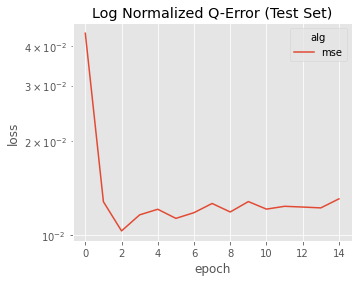

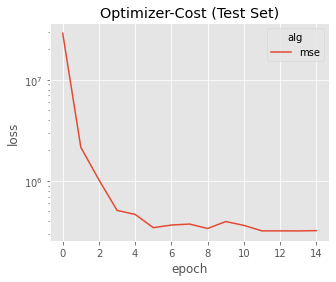

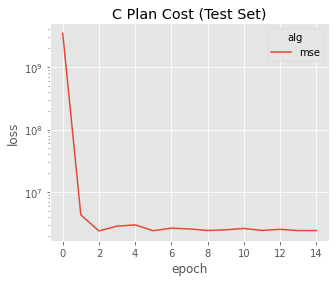

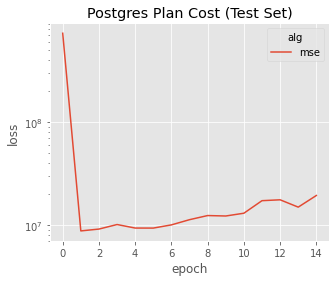

2


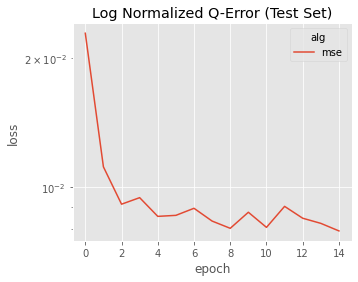

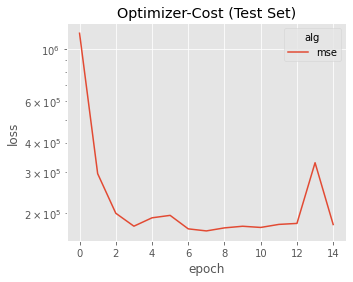

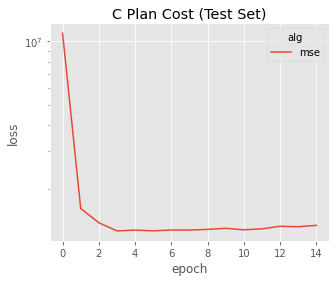

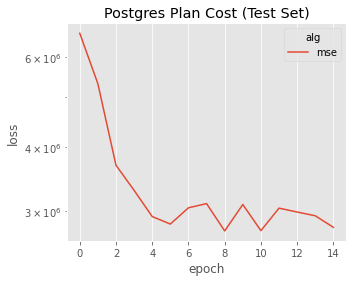

6


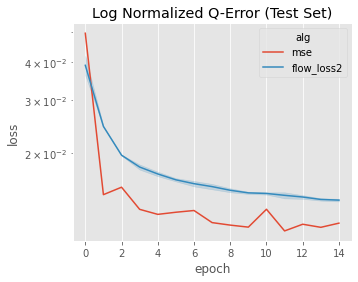

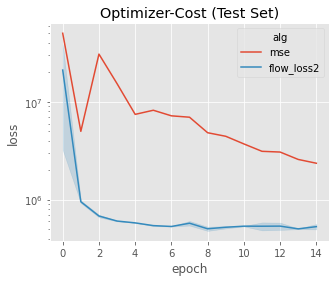

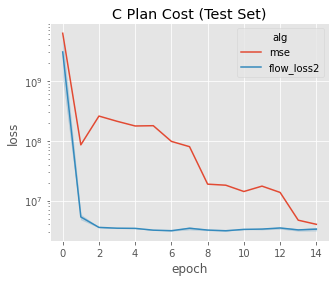

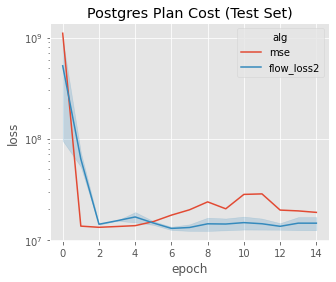

7


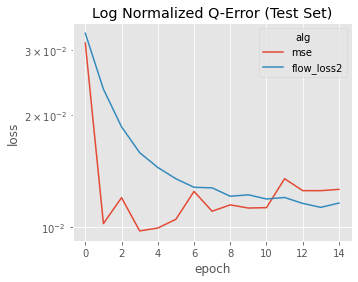

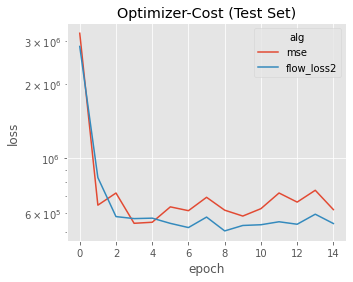

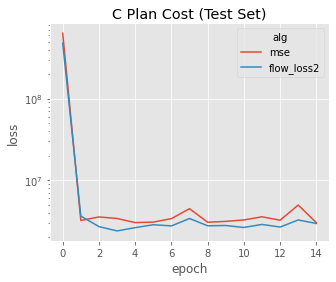

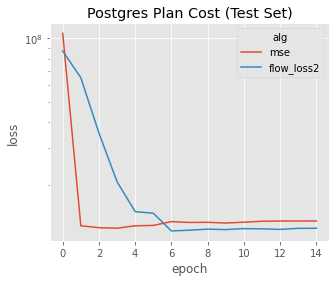

In [30]:
STS = ["test"]
LTS = ["qerr", "flow_cost", "mm1_plan_cost", "pp_cost"]

for part in set(df["partition"]):
    print(part)
    tmpdf = df[df.partition == part]
    for st in STS:
        for lt in LTS:
            plot_learning_curve(tmpdf, lt, st, "all")

In [42]:
set(all_df1["max_epochs"])

{15}

In [43]:
set(all_df1["loss_func"])

{'flow_loss2'}

In [21]:
print(set(df["loss_type"]))

{'mm1_plan_cost', 'flow_cost', 'flow_ratio', 'jerr', 'mm1_plan_pg_ratio', 'pp_cost', 'mm1_plan_err', 'mm1_plan_ratio', 'qerr', 'flow_err', 'jerr_ratio', 'mm1_plan_pg_err'}


In [26]:
print(set(df["lr"]))

{1e-05, 0.0001}
